In [1]:
import matplotlib.pyplot as plt

import main as lightcode
import hardware as hw
import graph_transformations as gt
import stacked_graph as sg
import input_validation as validate
import data_collection as dc
import code_generation as cg

# Prefill stage between photonic and electronic across various sequence lengths 

In [6]:
cpu_moc_sequence_len = []
cpu_makespan = []
cpu_total_energy = []

# relay_path = "models/gpt2_graph.json" # 5
# relay_path = "models/gpt2_prefill_graph.json"
# relay_path = "models/gpt2_decoder_graph.json" # 6
# relay_path = "models/Llama-2-7b-hf_graph.json" # 6
relay_path = "models/opt0_Llama-2-7b-hf_graph.json" # 6
# relay_path = "models/llama_2_7b_decoder_graph.json" # 11

'''
The numbers corospond to the sequence length the trace was made on. This is the
number that must be changed in /lightcode/stacked_graph.py calls to get_moc_size.
This is how it knows what the shapes are dynamically sized based uppon the input
sequence. Will try to make a better wrapper later
These numbers were chosen because they dont appear anywehre else in the dimentions
of operations in either GPT2 or llama-2-7b-hf
'''

optimization = "time"
# optimization = "energy"

CPU_MAX_CLOCK = 5.0875 * 10**9  # 5.0875 e+9 5Ghz
CPU_AVERAGE_CLOCK = 3.208 * 10**9  # 60**9, 6
PHU_MIN_CLOCK = 9.7 * 10**9  # 100**9, 10 Ghz

hw.Hardware._hardware_reset()
hardware = [
    hw.CPU(CPU_AVERAGE_CLOCK, 1),
]

available_hardware = hw.initilize_hardware(hardware)

for length in range(50):
    length = length * 30
    sim_result = lightcode.graph_search(
        relay_path,
        optimization,
        available_hardware,
        moc_sequence_length = length,
        profiles=True,
        data_collection=False,
    )

    cpu_moc_sequence_len.append(sim_result["moc_sequence_length"])
    cpu_makespan.append(sim_result["Makespan"])
    cpu_total_energy.append(sim_result["total_energy"])


In [3]:
phu_moc_sequence_len = []
phu_makespan = []
phu_total_energy = []


hw.Hardware._hardware_reset()
hardware = [
    hw.CPU(CPU_AVERAGE_CLOCK, 1),
    hw.PHU(PHU_MIN_CLOCK, 1, 20),
]

available_hardware = hw.initilize_hardware(hardware)

for length in range(50):
    length = length * 30
    sim_result = lightcode.graph_search(
        relay_path,
        optimization,
        available_hardware,
        moc_sequence_length = length,
        profiles=True,
        data_collection=False,
    )

    phu_moc_sequence_len.append(sim_result["moc_sequence_length"])
    phu_makespan.append(sim_result["Makespan"])
    phu_total_energy.append(sim_result["total_energy"])


NameError: name 'phu_moc_sequence_len' is not defined

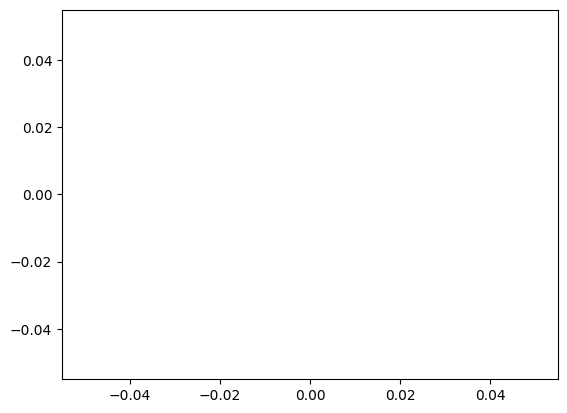

In [3]:
plt.plot(cpu_moc_sequence_len, cpu_makespan, marker='o', label='cpu')
plt.plot(phu_moc_sequence_len, phu_makespan, marker='o', label='phu')

# Add titles and labels
# llama-2-7b-hf
plt.title('Prefill Stage GPT2')
plt.xlabel('Sequence Length')
plt.ylabel('Makespan')

# Display the plot
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'phu_moc_sequence_len' is not defined

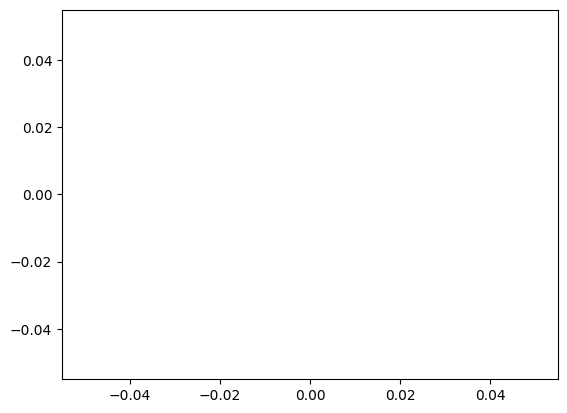

In [4]:
plt.plot(cpu_moc_sequence_len, cpu_total_energy, marker='o', label='cpu')
plt.plot(phu_moc_sequence_len, phu_total_energy, marker='o', label='phu')

# Add titles and labels
plt.title('Prefill Stage GPT2')
plt.xlabel('Sequence Length')
plt.ylabel('total_energy')

# Display the plot
plt.grid(True)
plt.legend()
plt.show()

In [5]:
print(cpu_makespan)
print(phu_makespan)
print(cpu_total_energy)
print(phu_total_energy)


[]


NameError: name 'phu_makespan' is not defined

# Decoder stage across sequence length

In [8]:

import torch
from transformers import LlamaForCausalLM, LlamaTokenizer

def tokenize_input(prompt, tokenizer):
    return tokenizer(prompt, return_tensors="pt")

def get_kv_cache(model, sequence_len):
    if hasattr(model.config, "n_head"):  # GPT-2 case
        num_heads = model.config.n_head
        head_dim = model.config.n_embd // model.config.n_head
    elif hasattr(model.config, "num_attention_heads"):  # LLaMA case
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // model.config.num_attention_heads
    else:
        raise ValueError(
            "Model config does not have expected attributes for attention heads or hidden size."
        )

    return torch.zeros(1, num_heads, sequence_len, head_dim)

model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "gpt2"

tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name, torchscript=True)

model.eval()

tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cpu")
model = model.to(device)

prompt = "The future of AI is going to be"
inputs = tokenize_input(prompt, tokenizer)

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

sequence_len = len(input_ids[0])
input_ids_shape = (1, sequence_len)

print(sequence_len)
print(input_ids_shape)

kv_cache_shape = get_kv_cache(model, sequence_len).shape

print(kv_cache_shape)


/home/rjtomich/miniconda3/envs/newest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

10
(1, 10)
torch.Size([1, 32, 10, 128])
